In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import OpenFLASH Core Modules
from openflash.basic_region_geometry import BasicRegionGeometry
from openflash.meem_problem import MEEMProblem
from openflash.meem_engine import MEEMEngine
from openflash.multi_equations import wavenumber

# Plotting configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Define Simulation Parameters
Here we define a two-step heaving cylinder (similar to the mini_bicylinder from tests).

In [9]:
# --- Constants ---
rho = 1023   # Water density (kg/m^3)
g = 9.81     # Gravity (m/s^2)
h = 1.001    # Water depth (m)

# --- Geometry Definition ---
# A cylinder with two steps (radii a, drafts d)
a_vals = np.array([0.125, 0.25])
d_vals = np.array([0.25, 0.125])

# Harmonics (NMK): One per domain (Inner + 1 Annulus + Outer = 3 domains)
NMK = [50, 50, 50] 

# --- Body Mapping ---
# Both steps belong to "Body 0"
body_map = [0, 0] 

# FIX: heaving_map is per-BODY, not per-step.
# Since we have only 1 body (Body 0), this list should have length 1.
heaving_map = [True] 

print(f"Simulation Depth: {h}m")
print(f"Radii: {a_vals}")
print(f"Drafts: {d_vals}")
print(f"Body Map: {body_map}")
print(f"Heaving Map: {heaving_map}")

Simulation Depth: 1.001m
Radii: [0.125 0.25 ]
Drafts: [0.25  0.125]
Body Map: [0, 0]
Heaving Map: [True]


Initialize OpenFLASH System

In [10]:
# 1. Create Geometry Object
# We use from_vectors for robust setup of multi-step bodies
geometry = BasicRegionGeometry.from_vectors(
    a=a_vals,
    d=d_vals,
    h=h,
    NMK=NMK,
    slant_angle=np.zeros_like(a_vals), # Vertical walls
    body_map=body_map,
    heaving_map=heaving_map
)

# 2. Create Problem and Engine
problem = MEEMProblem(geometry)
engine = MEEMEngine([problem])

print("OpenFLASH System Initialized Successfully.")

OpenFLASH System Initialized Successfully.


Geometry Visualization
This draws the physical setup of the problem (stepped cylinder and water depth) so can verify the geometry before solving.

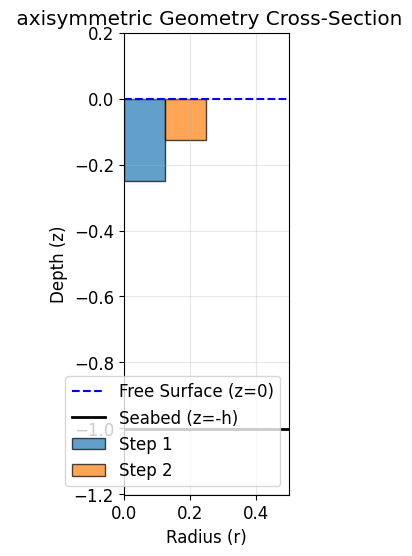

In [11]:
# --- Visualizing the Geometry ---
fig, ax = plt.subplots(figsize=(6, 6))

# 1. Plot Water Depth
ax.axhline(0, color='blue', linestyle='--', label='Free Surface (z=0)')
ax.axhline(-h, color='black', linewidth=2, label='Seabed (z=-h)')

# 2. Plot the Body Steps
# We define rectangles based on radius (a) and draft (d)
current_r = 0.0
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Colors for different steps

for i, (radius, draft) in enumerate(zip(a_vals, d_vals)):
    # Annulus width for this step
    width = radius - current_r
    
    # Draw rectangle: (x, y) = (inner_radius, -draft)
    rect = plt.Rectangle((current_r, -draft), width, draft, 
                         facecolor=colors[i % len(colors)], 
                         edgecolor='black', alpha=0.7, label=f'Step {i+1}')
    ax.add_patch(rect)
    current_r = radius

# 3. Styling
ax.set_xlim(0, max(a_vals) * 2.0)
ax.set_ylim(-h * 1.2, 0.2)
ax.set_xlabel('Radius (r)')
ax.set_ylabel('Depth (z)')
ax.set_title(' axisymmetric Geometry Cross-Section')
ax.set_aspect('equal')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.show()

Single Frequency SolutionSolve the linear system for a specific frequency ($\omega = 2.0$ rad/s).

In [12]:
# Target Frequency
omega = 2.0
m0 = wavenumber(omega, h)

print(f"Solving for Omega = {omega:.2f} rad/s (Wavenumber m0 = {m0:.4f})...")

# Solve Linear System
X = engine.solve_linear_system_multi(problem, m0)

# Compute Hydrodynamic Coefficients
coeffs = engine.compute_hydrodynamic_coefficients(problem, X, m0, rho=rho)

# Display Results
print("\n--- Results ---")
for res in coeffs:
    # Use res.get() to safely access keys, or just print the Mode
    mode_idx = res.get('mode', 'Unknown')
    print(f"Mode {mode_idx}:")
    print(f"  Added Mass: {res['real']:.4f} kg")
    print(f"  Damping:    {res['imag']:.4f} kg/s")
    
    # Check if excitation keys exist before printing (they should for wave problems)
    if 'excitation_force' in res:
        print(f"  Exc. Force: {res['excitation_force']:.4f} N")
    if 'excitation_phase' in res:
        print(f"  Exc. Phase: {res['excitation_phase']:.4f} rad")
    print("-" * 20)

Solving for Omega = 2.00 rad/s (Wavenumber m0 = 0.6850)...

--- Results ---
Mode 0:
  Added Mass: 32.0749 kg
  Damping:    20.1062 kg/s
  Exc. Force: 41.6157 N
  Exc. Phase: -0.0233 rad
--------------------


Intercept the System MatrixThis cell defines a helper class to "spy" on numpy.linalg.solve and capture the matrix $A$ and vector $b$ when engine.solve_linear_system_multi runs.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg

# --- Matrix Interception Helper ---
class MatrixSpy:
    """
    Context manager to intercept the matrix 'A' passed to 
    either numpy.linalg.solve OR scipy.linalg.solve.
    """
    def __init__(self):
        self.A = None
        self.b = None
        self._orig_np_solve = np.linalg.solve
        self._orig_sp_solve = scipy.linalg.solve

    def __enter__(self):
        # 1. Define wrapper for NumPy
        def np_spy(a, b, *args, **kwargs):
            self.A = a
            self.b = b
            return self._orig_np_solve(a, b, *args, **kwargs)

        # 2. Define wrapper for SciPy
        def sp_spy(a, b, *args, **kwargs):
            self.A = a
            self.b = b
            return self._orig_sp_solve(a, b, *args, **kwargs)
        
        # 3. Apply the patches
        np.linalg.solve = np_spy
        scipy.linalg.solve = sp_spy
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        # Restore original functions
        np.linalg.solve = self._orig_np_solve
        scipy.linalg.solve = self._orig_sp_solve

# --- Capture the Matrix ---
print(f"Re-solving for Omega = {omega:.2f} to capture system matrix...")

with MatrixSpy() as spy:
    # Run the solver again (result X is ignored)
    _ = engine.solve_linear_system_multi(problem, m0)

# Check if we successfully captured it
if spy.A is not None:
    captured_matrix = spy.A
    print(f"Matrix Captured. Shape: {captured_matrix.shape}")
else:
    print("Error: Could not capture matrix. The engine might be using a different solver (e.g., lstsq or inv).")
    # Create a dummy matrix so the next cell doesn't crash
    captured_matrix = np.eye(10)

Re-solving for Omega = 2.00 to capture system matrix...
Matrix Captured. Shape: (200, 200)


Plot Matrix Sparsity and Thresholds
This cell generates the two specific plots:

Non-Zero Entries: Visualizes the raw structure of the matrix.

Entries Below Threshold: Visualizes "noise" or checks for values that should be zero but aren't (or vice versa).

Saved 'A_values_openflash.csv' to simulate external data input.
Comparison complete. Matching entries saved to 'A_match_check.txt'.


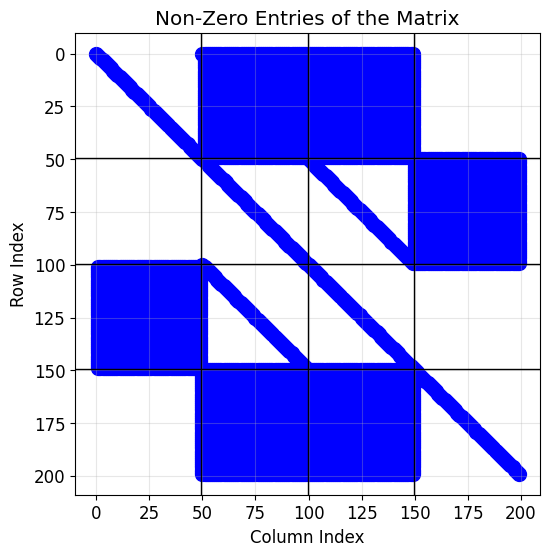

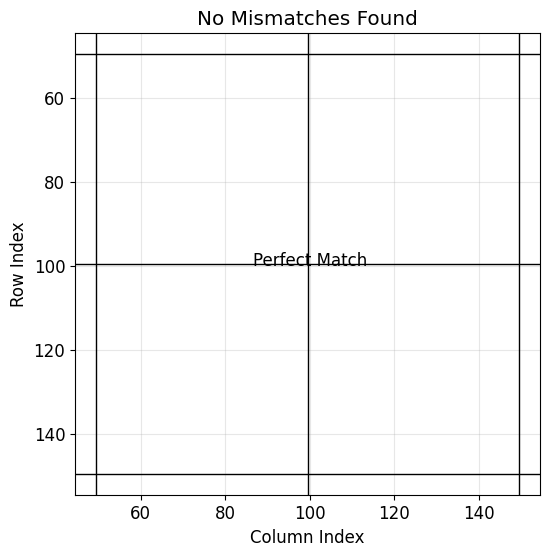

Total Non-Zeros: 15103
Total Mismatches: 0


In [14]:
import pandas as pd

# --- 1. SETUP: Mimic the "External Data" from MEEM.ipynb ---
if 'captured_matrix' not in locals() or captured_matrix is None:
    raise ValueError("Please run the 'MatrixSpy' cell above to capture the system matrix first.")

# FIX: Use Pandas to save the matrix. 
# This avoids the complex formatting error in np.savetxt and ensures compatibility.
pd.DataFrame(captured_matrix).to_csv("A_values_openflash.csv", header=False, index=False)
print("Saved 'A_values_openflash.csv' to simulate external data input.")

# --- 2. LOAD DATA (Matching MEEM.ipynb Logic) ---
file_path = 'A_values_openflash.csv'
df = pd.read_csv(file_path, header=None)

# Function from MEEM.ipynb to parse complex numbers
def to_complex(val):
    try:
        # Handle standard string conversion
        return np.complex128(val)
    except Exception:
        # Fallback for different formatting (e.g. replacing 'i' with 'j' or removing parens)
        try:
            val_str = str(val).replace('i', 'j').replace('(', '').replace(')', '')
            return np.complex128(val_str)
        except:
            return np.nan

# Convert loaded data to complex numpy array
# Apply map element-wise to handle the string-to-complex conversion
df_complex = df.map(to_complex) 
A_num = df_complex.to_numpy()

# --- 3. COMPARE: Analytical (OpenFLASH) vs Numerical (CSV) ---
A_analytical = captured_matrix
threshold = 1e-10

# Check for matches
# We align shapes just in case (pandas might read an extra index column if not careful)
if A_num.shape != A_analytical.shape:
    print(f"Shape Warning: Loaded {A_num.shape} vs Captured {A_analytical.shape}. Trimming to match.")
    min_rows = min(A_num.shape[0], A_analytical.shape[0])
    min_cols = min(A_num.shape[1], A_analytical.shape[1])
    A_num = A_num[:min_rows, :min_cols]
    A_analytical = A_analytical[:min_rows, :min_cols]

is_within_threshold = np.isclose(A_num, A_analytical, rtol=threshold, atol=threshold)

# Save comparison results
np.savetxt("A_match_check.txt", is_within_threshold, fmt='%d')
print(f"Comparison complete. Matching entries saved to 'A_match_check.txt'.")

# --- 4. VISUALIZATION (Exact MEEM.ipynb Style) ---

# Calculate Block Boundaries for Grid Lines
boundaries = []
current_idx = 0
for n_modes in NMK:
    current_idx += n_modes
    boundaries.append(current_idx)
if boundaries[-1] == A_analytical.shape[0]: boundaries.pop()

# --- Plot 1: Non-Zero Entries of the Matrix ---
rows, cols = np.nonzero(np.abs(A_analytical) > 1e-15)

plt.figure(figsize=(6, 6))
plt.scatter(cols, rows, color='blue', marker='o', s=100) 
plt.gca().invert_yaxis() 

matrix_size = A_analytical.shape[0]
if matrix_size < 30:
    plt.xticks(range(matrix_size))
    plt.yticks(range(matrix_size))

for val in boundaries:
    plt.axvline(val-0.5, color='black', linestyle='-', linewidth=1) 
    plt.axhline(val-0.5, color='black', linestyle='-', linewidth=1) 

plt.grid(True, alpha=0.3)
plt.title('Non-Zero Entries of the Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

# --- Plot 2: Non-Zero Entries Not Matching the Threshold ---
# This matches the "Blue Dots = Mismatch" style from MEEM.ipynb
rows_mismatch, cols_mismatch = np.nonzero(~is_within_threshold)

plt.figure(figsize=(6, 6))

if len(rows_mismatch) > 0:
    plt.scatter(cols_mismatch, rows_mismatch, color='blue', marker='o', s=100)
    title_text = 'Non-Zero Entries Not Matching Threshold'
else:
    plt.text(matrix_size/2, matrix_size/2, "Perfect Match", ha='center', fontsize=12)
    title_text = 'No Mismatches Found'

plt.gca().invert_yaxis()

if matrix_size < 30:
    plt.xticks(range(matrix_size))
    plt.yticks(range(matrix_size))

for val in boundaries:
    plt.axvline(val - 0.5, color='black', linestyle='-', linewidth=1)
    plt.axhline(val - 0.5, color='black', linestyle='-', linewidth=1)

plt.grid(True, alpha=0.3)
plt.title(title_text)
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

print(f"Total Non-Zeros: {len(rows)}")
print(f"Total Mismatches: {len(rows_mismatch)}")

Matrix Structure & Threshold Visualization

Calculated Block Boundaries: [50, 100, 150]


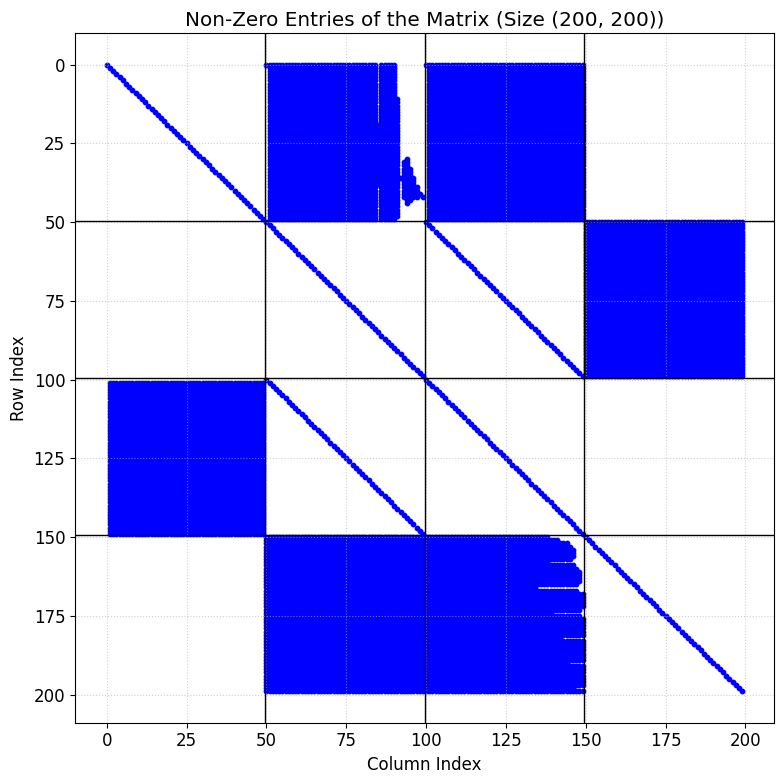

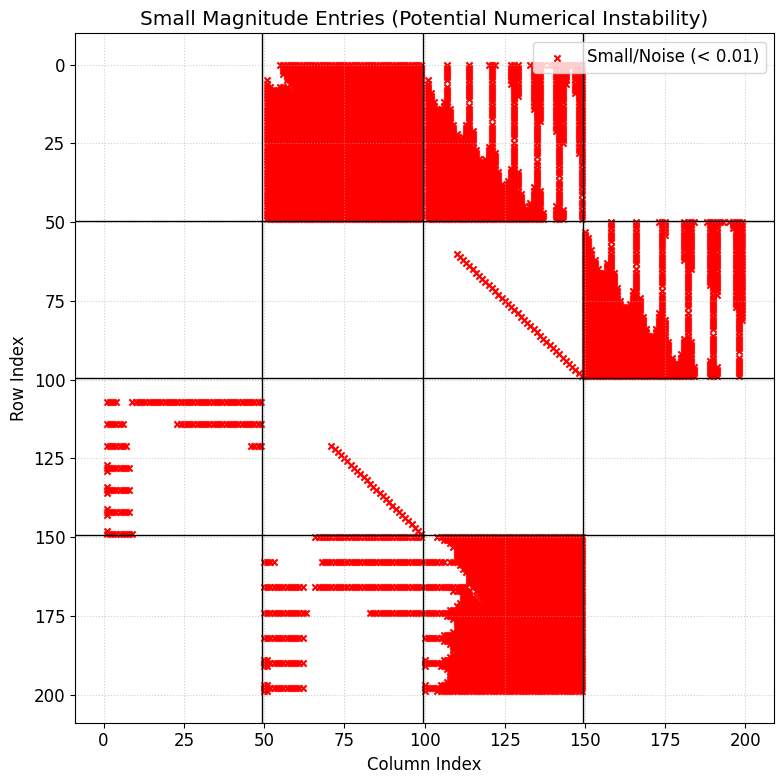

In [15]:
# --- Configuration ---
# Threshold for "Non-Zero" (Physics) vs "Numerical Noise"
noise_threshold = 1e-10 

# Get the matrix captured by MatrixSpy in the previous cell
if 'captured_matrix' not in locals() or captured_matrix is None:
    raise ValueError("Please run the 'MatrixSpy' cell above to capture the system matrix first.")

A_final = captured_matrix

# --- 1. Calculate Grid Lines (Block Boundaries) ---
# MEEM matrices are structured as: [Inner] -> [Annulus 1_a] -> [Annulus 1_b] -> ... -> [Outer]
boundaries = []
current_idx = 0

# Inner Region (1 block)
if len(NMK) > 0:
    current_idx += NMK[0]
    boundaries.append(current_idx)

# Annular Regions (2 blocks each)
for k in range(1, len(NMK) - 1):
    # Part 1 of Annulus coefficients
    current_idx += NMK[k]
    boundaries.append(current_idx)
    # Part 2 of Annulus coefficients
    current_idx += NMK[k]
    boundaries.append(current_idx)

# Outer Region (1 block) - ends at the matrix dimension, no line needed usually
print(f"Calculated Block Boundaries: {boundaries}")

# --- 2. Plot 1: Non-Zero Entries (Structure) ---
rows, cols = np.nonzero(np.abs(A_final) > noise_threshold)

plt.figure(figsize=(8, 8))
plt.scatter(cols, rows, color='blue', marker='o', s=10) # 's' is marker size
plt.gca().invert_yaxis() # Matrix convention: row 0 at top

# Draw Block Grid Lines
for val in boundaries:
    plt.axvline(val - 0.5, color='black', linestyle='-', linewidth=1)
    plt.axhline(val - 0.5, color='black', linestyle='-', linewidth=1)

plt.grid(True, linestyle=':', alpha=0.6)
plt.title(f'Non-Zero Entries of the Matrix (Size {A_final.shape})')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

# --- 3. Plot 2: Low-Value Entries (Potential Numerical Artifacts) ---
# In MEEM.ipynb, this compared against a reference CSV. 
# Here, we visualize entries that are "Non-Zero but Small" (likely noise)
# vs "Significant Physics" to help debug stability.

# Define a "Small but not zero" range
upper_noise_limit = 1e-2
lower_noise_limit = 1e-15

# Find indices
mask_noise = (np.abs(A_final) < upper_noise_limit) & (np.abs(A_final) > lower_noise_limit)
rows_n, cols_n = np.nonzero(mask_noise)

plt.figure(figsize=(8, 8))

if len(rows_n) > 0:
    plt.scatter(cols_n, rows_n, color='red', marker='x', s=20, label=f'Small/Noise (< {upper_noise_limit})')
else:
    plt.text(A_final.shape[1]/2, A_final.shape[0]/2, "No entries in noise range", ha='center')

plt.gca().invert_yaxis()

# Draw Grid Lines
for val in boundaries:
    plt.axvline(val - 0.5, color='black', linestyle='-', linewidth=1)
    plt.axhline(val - 0.5, color='black', linestyle='-', linewidth=1)

plt.grid(True, linestyle=':', alpha=0.6)
plt.title('Small Magnitude Entries (Potential Numerical Instability)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --- 4. (Optional) Export for External Comparison ---
# This saves the matrix so can use it as 'A_values.csv' in the future
# np.savetxt("openflash_A_matrix_real.csv", np.real(A_final), delimiter=",")
# np.savetxt("openflash_A_matrix_imag.csv", np.imag(A_final), delimiter=",")
# print("Matrix dumped to CSV for comparison.")

Visualize Potential Field
Generate a contour plot of the velocity potential around the body.

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_12983/1778636678.py:12: SyntaxWarning: invalid escape sequence '\p'
  "Real Part of Velocity Potential ($\phi_R$)"
/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_12983/1778636678.py:20: SyntaxWarning: invalid escape sequence '\p'
  "Imaginary Part of Velocity Potential ($\phi_I$)"


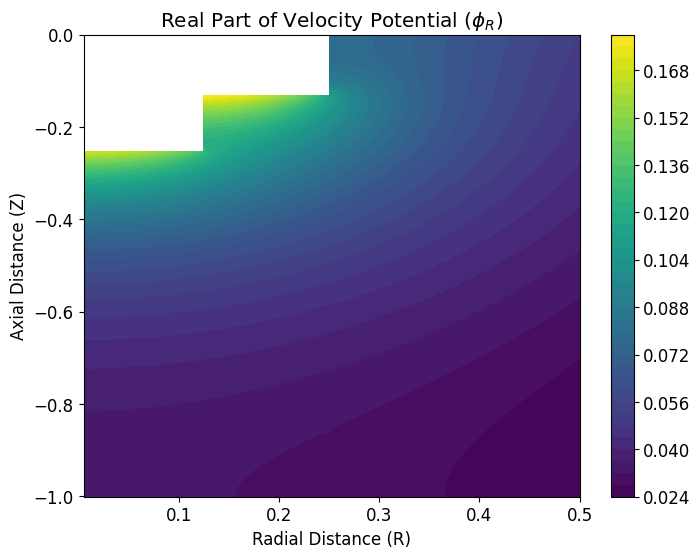

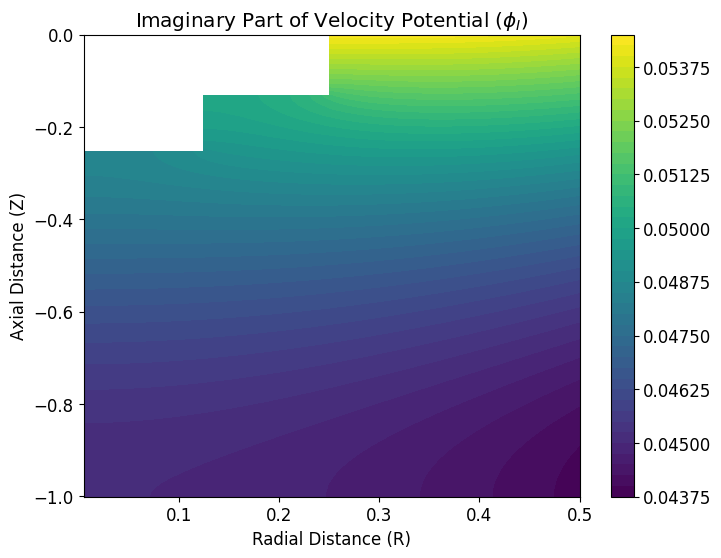

In [16]:
# Grid Resolution
resolution = 100

# Calculate Potential Field
potentials = engine.calculate_potentials(problem, X, m0, resolution, sharp=True)
R, Z, phi = potentials["R"], potentials["Z"], potentials["phi"]

# Plot Real Part (Velocity Potential in phase with velocity)
fig, ax = engine.visualize_potential(
    np.real(phi), 
    R, Z, 
    "Real Part of Velocity Potential ($\phi_R$)"
)
plt.show()

# Plot Imaginary Part (Velocity Potential out of phase)
fig, ax = engine.visualize_potential(
    np.imag(phi), 
    R, Z, 
    "Imaginary Part of Velocity Potential ($\phi_I$)"
)
plt.show()

Pressure & Surface Elevation (Insert after Cell 5)MEEM.ipynb calculates Pressure ($P$) and Elevation ($\eta$) from the velocity potential. Here is the math translated to OpenFLASH:Dynamic Pressure: $P = -\rho \cdot i \omega \cdot \phi$Surface Elevation: $\eta = \frac{i \omega}{g} \cdot \phi|_{z=0}$

<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:31: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:34: SyntaxWarning: invalid escape sequence '\e'
/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_12983/122015789.py:30: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(r_surface, np.real(eta), 'b-', label='Real $\eta$ (In Phase)')
/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_12983/122015789.py:31: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(r_surface, np.imag(eta), 'r--', label='Imag $\eta$ (Out Phase)')
/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_12983/122015789.py:32: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(r_surface, np.abs(eta), 'k-', linewidth=2, alpha=0.3,

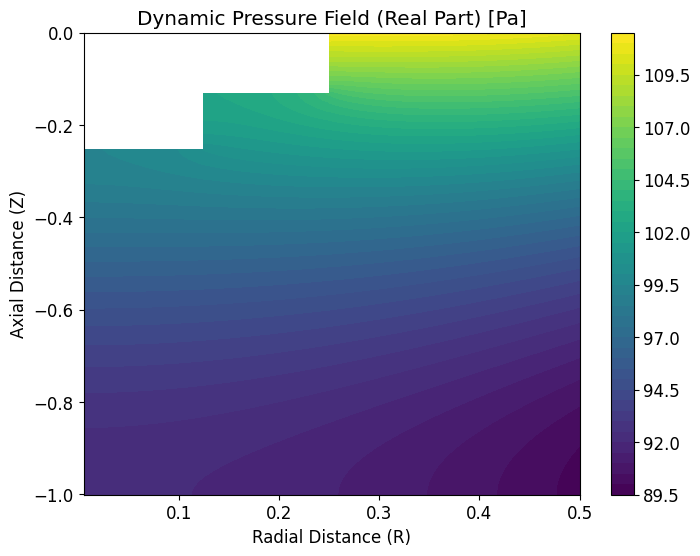

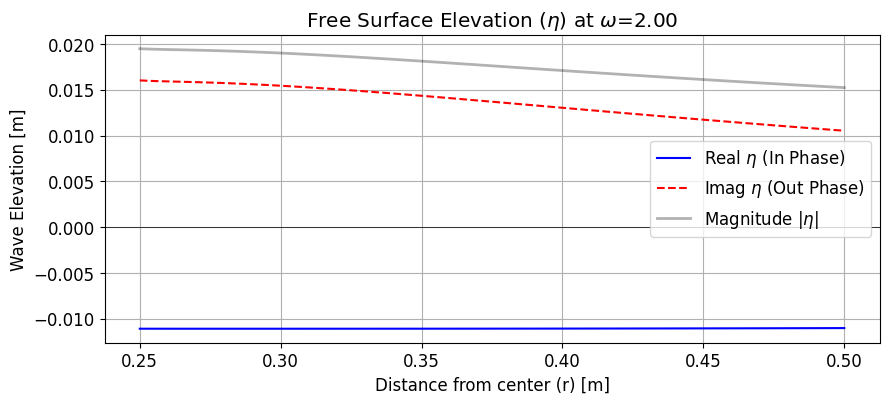

In [17]:
# --- Physics Calculations ---
# P = -rho * i * omega * phi
# eta = (i * omega / g) * phi_at_surface

# 1. Calculate Pressure Field
pressure_field = -rho * 1j * omega * phi

# 2. Visualize Pressure (Real Part - "In Phase")
fig, ax = engine.visualize_potential(
    np.real(pressure_field), 
    R, Z, 
    "Dynamic Pressure Field (Real Part) [Pa]"
)
plt.show()

# 3. Calculate Free Surface Elevation (eta)
# We extract the potential at z=0 (assumed to be the top row of our grid if generated top-down)
# Or we just use the calculated grid:
surface_indices = np.where(np.isclose(Z, 0, atol=1e-3))

# Extract R at surface and Phi at surface
r_surface = R[surface_indices]
phi_surface = phi[surface_indices]

# Calculate eta
eta = (1j * omega / g) * phi_surface

# 4. Plot Free Surface Elevation
plt.figure(figsize=(10, 4))
plt.plot(r_surface, np.real(eta), 'b-', label='Real $\eta$ (In Phase)')
plt.plot(r_surface, np.imag(eta), 'r--', label='Imag $\eta$ (Out Phase)')
plt.plot(r_surface, np.abs(eta), 'k-', linewidth=2, alpha=0.3, label='Magnitude $|\eta|$')

plt.title(f'Free Surface Elevation ($\eta$) at $\omega$={omega:.2f}')
plt.xlabel('Distance from center (r) [m]')
plt.ylabel('Wave Elevation [m]')
plt.axhline(0, color='k', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

Frequency Sweep
Run a sweep across a range of frequencies to generate the Added Mass and Damping curves.

In [18]:
# Define Frequency Range
omega_start = 0.5
omega_end = 4.0
steps = 30
omegas = np.linspace(omega_start, omega_end, steps)

print(f"Running frequency sweep from {omega_start} to {omega_end} rad/s ({steps} steps)...")

# Update Problem Frequencies
problem.set_frequencies(omegas)

# Run Sweep (using the engine's batch runner)
results_obj = engine.run_and_store_results(problem_index=0)
ds = results_obj.get_results() # Returns an xarray Dataset

# Convert to Pandas for easy plotting
df = ds[['added_mass', 'damping']].to_dataframe().reset_index()

# Filter for the relevant mode (Heave, usually mode_i=0, mode_j=0 for single body)
# Adjust mode indices if have multiple bodies
heave_data = df[(df['mode_i'] == 0) & (df['mode_j'] == 0)]

print("Sweep Complete.")

Running frequency sweep from 0.5 to 4.0 rad/s (30 steps)...
Hydrodynamic coefficients stored in xarray dataset.
Potentials stored in xarray dataset (batched across frequencies/modes).
Sweep Complete.


Plot Frequency Sweep Results

<>:30: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\o'
/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_12983/1898491630.py:30: SyntaxWarning: invalid escape sequence '\o'
  ax3.set_xlabel('Frequency $\omega$ [rad/s]')
/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_12983/1898491630.py:38: SyntaxWarning: invalid escape sequence '\p'
  ax4.set_ylabel('Phase ($\phi$) [rad]')
/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_12983/1898491630.py:40: SyntaxWarning: invalid escape sequence '\o'
  ax4.set_xlabel('Frequency $\omega$ [rad/s]')


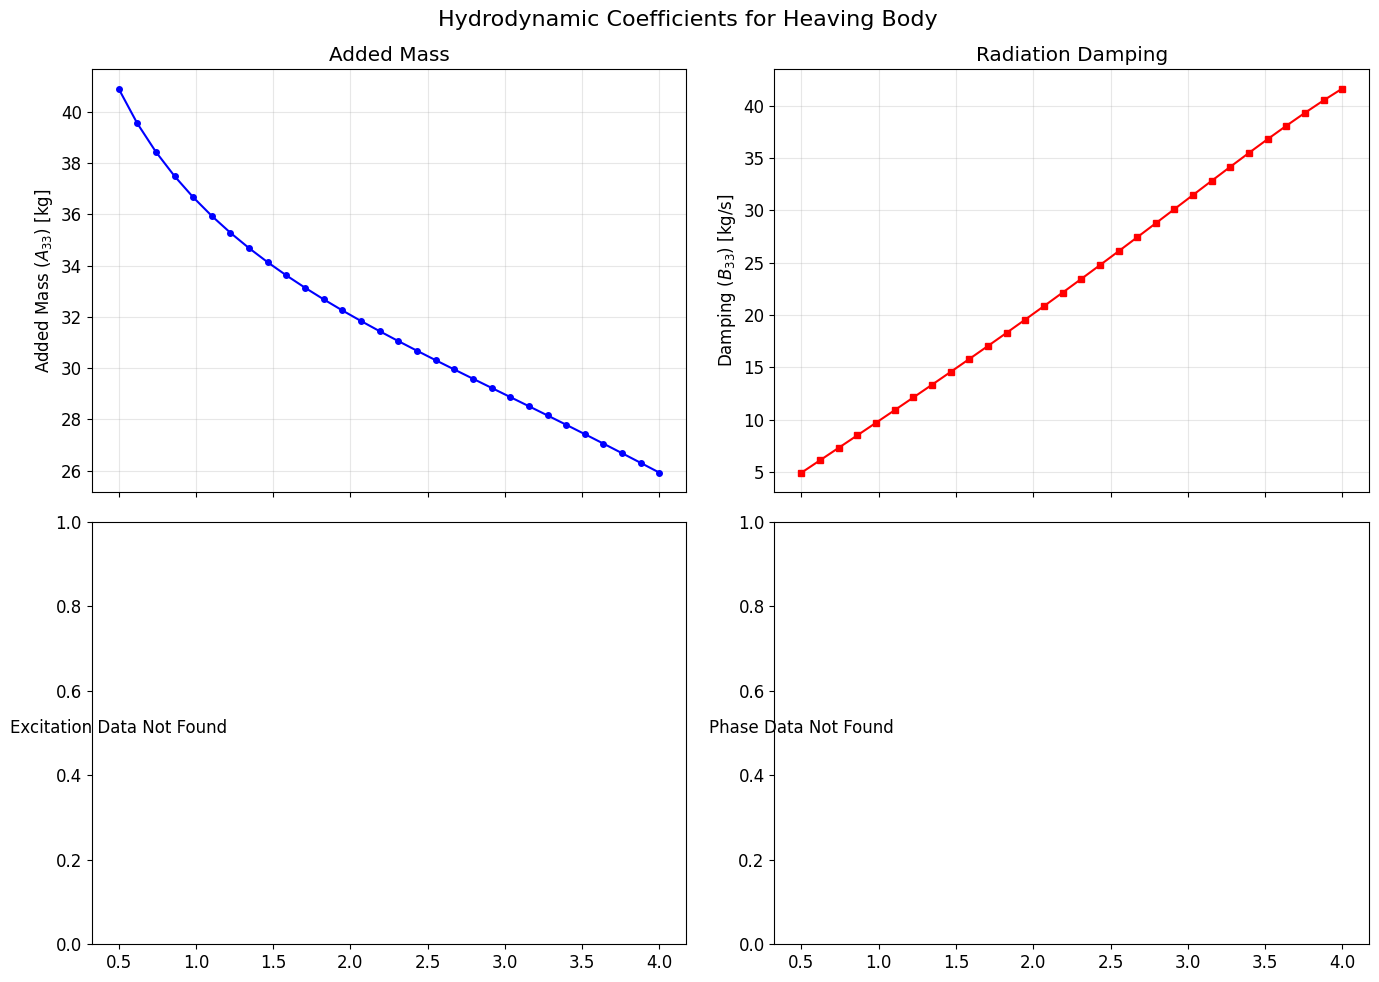

In [19]:
# --- Full Hydrodynamic Coefficient Plots ---

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
((ax1, ax2), (ax3, ax4)) = axes

# Filter for the relevant mode (Heave: 0,0)
# Note: Ensure results DataFrame columns match.
# 'mode_i' and 'mode_j' might be needed depending on how xarray converted it.
heave_data = df[(df['mode_i'] == 0) & (df['mode_j'] == 0)]

# 1. Added Mass
ax1.plot(heave_data['frequency'], heave_data['added_mass'], 'b-o', markersize=4)
ax1.set_ylabel('Added Mass ($A_{33}$) [kg]')
ax1.set_title('Added Mass')
ax1.grid(True, alpha=0.3)

# 2. Damping
ax2.plot(heave_data['frequency'], heave_data['damping'], 'r-s', markersize=4)
ax2.set_ylabel('Damping ($B_{33}$) [kg/s]')
ax2.set_title('Radiation Damping')
ax2.grid(True, alpha=0.3)

# 3. Excitation Force Magnitude
# Usually labeled 'excitation_force' or 'force_mag' in the dataset
if 'excitation_force' in heave_data.columns:
    ax3.plot(heave_data['frequency'], heave_data['excitation_force'], 'g-^', markersize=4)
    ax3.set_ylabel('Excitation Force ($|F_X|$) [N/m]')
    ax3.set_title('Excitation Force Magnitude')
    ax3.set_xlabel('Frequency $\omega$ [rad/s]')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, "Excitation Data Not Found", ha='center')

# 4. Excitation Phase
if 'excitation_phase' in heave_data.columns:
    ax4.plot(heave_data['frequency'], heave_data['excitation_phase'], 'm-d', markersize=4)
    ax4.set_ylabel('Phase ($\phi$) [rad]')
    ax4.set_title('Excitation Phase')
    ax4.set_xlabel('Frequency $\omega$ [rad/s]')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, "Phase Data Not Found", ha='center')

plt.suptitle(f"Hydrodynamic Coefficients for Heaving Body", fontsize=16)
plt.tight_layout()
plt.show()